In [1]:
%pylab inline
from qsystem_2 import PfbSoc, freq2reg
from tqdm import tqdm_notebook as tqdm
from qsystem2_asm import *
#from averager_program import AveragerProgram
from slab.instruments import InstrumentManager
import time


#qubit is on 229 ch 3
#readout is on 229 ch 2
#storage is on 229 ch 1
#JPA is on 229 ch 0

Populating the interactive namespace from numpy and matplotlib


Warning serial library import failed.
Warning could not load Chase AWG dll, check that dll located at 'C:\_Lib\python\slab\instruments\awg\chase\dax22000_lib_DLL32.dll'
Could not load InstrumentManagerWindow
Warning could not load LDA labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_atten.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LPS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_dps.dll'
Could not load labbrick


/usr/lib/python3/dist-packages/IPython/qt.py:13: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  "You should import from qtconsole instead.", ShimWarning)


In [2]:
# Load bitstream with custom overlay
soc = PfbSoc('qsystem_2.bit')
im=InstrumentManager(ns_address='192.168.14.1')
rLO=im['RF8']
#rLO.set_frequency(8.1516e9)
rLO.set_frequency(6.9516e9)

In [3]:
class AveragerProgram(ASM_Program):
    def __init__(self, cfg):
        ASM_Program.__init__(self)
        self.cfg=cfg
        self.make_program()
    
    def initialize(self):
        pass
    
    def body(self):
        pass
    
    def make_program(self):
        p=self
        
        rcount=12
        rjj=14

        p.initialize()
        p.regwi (0, rcount,0)
        p.regwi (0, rjj, self.cfg["reps"]-1)
        p.label("LOOP_J")

        p.body()

        p.mathi(0,rcount,rcount,"+",1)
        
        p.memwi(0,rcount,1)
                
        p.loopnz(0, rjj, 'LOOP_J')
       
        p.end()        
        
    def acquire(self, soc, load_pulses=True, progress=True):

        if load_pulses: 
            self.load_pulses(soc)
        # Readout configuration to route input without frequency translation.
        
        for readout,adc_freq in zip(soc.readouts,self.cfg["adc_freqs"]):
            readout.set_out(sel="product")
            readout.set_freq(adc_freq)
            #readout.dds_freq_reg=adc_freq
            #print (adc_freq)
        
        # Configure buffer capture.
        for avg_buf,adc_length in zip(soc.avg_bufs, self.cfg["adc_lengths"]):
            avg_buf.config_buf(address=0,length=adc_length)
            avg_buf.config_avg(address=0,length=adc_length)

            # Enable buffer capture.
            avg_buf.enable_buf()
            avg_buf.enable_avg()

        soc.tproc.load_asm_program(self)
        
        reps = self.cfg['reps']
        
        count=0
        last_count=0
        total_count=reps

        di_buf=np.zeros(total_count)
        dq_buf=np.zeros(total_count)
        
        soc.tproc.stop()
        
        soc.tproc.single_write(addr= 1,data=0)
        self.stats=[]
        
        soc.tproc.start()
        
        last_nn=0
        while count<total_count-1:
#             nn = soc.tproc.single_read(addr= 1)
#             if nn<last_nn:
#                 wrap=1
#             else:
#                 wrap=0
#             count=(count//2**16+wrap)*2**16 + nn
#             last_nn=nn
            count = soc.tproc.single_read(addr= 1)
            if count>=min(last_count+1000,total_count-1):
                addr=last_count % soc.avg_bufs[0].AVG_MAX_LENGTH
                length = count-last_count
                length -= length%2
                di,dq = soc.get_accumulated(ch=0,address=addr, length=length)

                di_buf[last_count:last_count+length]=di[:length]
                dq_buf[last_count:last_count+length]=dq[:length]

                last_count+=length
                self.stats.append( (time.time(), count,addr, length))
#                 pbar.update(last_count-pbar.n)
                #print (count,addr, length)
                    
        self.di_buf=di_buf
        self.dq_buf=dq_buf
        
        avg_di=np.sum(di_buf)/(reps)/self.cfg['adc_lengths'][0]
        avg_dq=np.sum(dq_buf)/(reps)/self.cfg['adc_lengths'][0]
        avg_amp=np.sqrt(avg_di**2+avg_dq**2)
        
        return avg_di, avg_dq, avg_amp
    
    

# Resonator Spectroscopy

In [4]:
config={"res_ch":6,
        "adc_lengths":[1000,1000], "res_gain":8000,"res_phase":0,
        "relax_delay":10, "frequency": 1000
       }

class ResonatorSpectroscopyProgram(AveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)
        
    def initialize(self):
        cfg=self.cfg   
        
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2
        self.add_pulse(ch=self.cfg["res_ch"], name="measure",style="const", length=self.cfg["readout_length"])
        freq=self.freq2reg(cfg["frequency"])
        
        self.pulse(ch=cfg["res_ch"], pulse="measure", freq=freq, phase=0, gain=cfg["res_gain"],  length=self.cfg['readout_length'] , t= 0, play=False)
        #soc.tproc.single_write(addr=123, data=self.freq2reg(cfg["frequency"]))
        #self.memri(self.ch_page(cfg["res_ch"]),self.sreg(cfg["res_ch"],"freq"),123)
        self.synci(200)
    
    def body(self):
        cfg=self.cfg 
        #self.measure(ch=self.cfg["res_ch"],  length=self.cfg['readout_length'], play=True)
        self.trigger_adc(adc1=1, adc2=1)
        self.pulse(ch=cfg["res_ch"], play=True)
        self.sync_all()
        self.delay(self.us2cycles(self.cfg["relax_delay"]))        

{'start': 1089.984375, 'step': 0.094, 'expts': 200, 'reps': 2000}


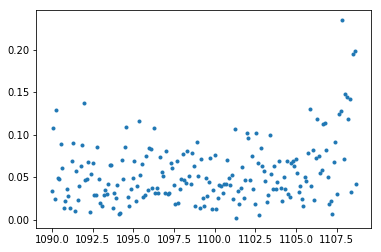

In [13]:
config={"res_ch":6,"reps": 2000,
        "readout_length":1000, "res_gain":5000,"res_phase":0,
        "relax_delay":10, "frequency": 1100
       }
#sweep_cfg={"start":1090, "step": .1, "expts":200, "reps": 2000}
#sweep_cfg={"start":rspec.freq2reg_adc(1090), "step": rspec.freq2reg_adc(0.1), "expts":200, "reps": 2000}
sweep_cfg={"start":1089.984375, "step":0.094, "expts":200, "reps": 2000}
print(sweep_cfg)
#reg_pts=sweep_cfg["start"]+sweep_cfg["step"]*arange(sweep_cfg["expts"])
#fpts=[rspec.reg2freq_adc(f) for f in reg_pts]
rspec=ResonatorSpectroscopyProgram(config)
fpts=sweep_cfg["start"]+sweep_cfg["step"]*arange(sweep_cfg["expts"])
fpts=[rspec.adcfreq(f) for f in fpts]
results=[]
for f in tqdm(fpts):
    #time.sleep(0.1)
    #config["frequency"]=rspec.reg2freq_adc(reg)
    #config["adc_freqs"]=[int(reg)]*2
    config["frequency"]=rspec.adcfreq(f)
    config["adc_freqs"]=[f,f]
    rspec=ResonatorSpectroscopyProgram(config)
    results.append(rspec.acquire(soc))
plot(fpts,np.array(results).T[2],'.')

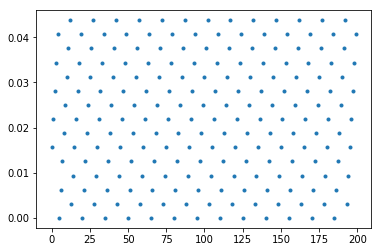

In [14]:
plot(fpts-np.array([rspec.adcfreq(f) for f in fpts]),'.')

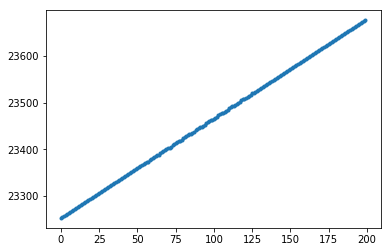

In [9]:
plot([rspec.freq2reg_adc(f) for f in fpts],'.')

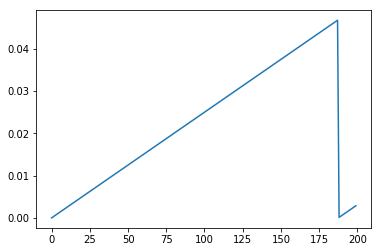

In [16]:
fpts2=[rspec.adcfreq(f) for f in fpts]
plot(fpts-fpts2)

In [22]:
config={"res_ch":6,"reps": 2000,
        "readout_length":1000, "res_gain":20000,"res_phase":0,
        "relax_delay":10, "frequency": 1100
       }
rspec=ResonatorSpectroscopyProgram(config)
rspec.acquire(soc)
di,dq = soc.get_decimated(ch=0,address=0, length=config["readout_length"])

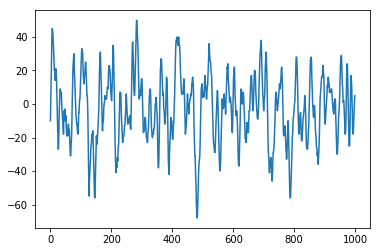

In [23]:
plot (dq)

In [24]:
rspec


// Program

        regwi 2, $24, 0;                        //phase = 0
        regwi 2, $26, 20000;                    //gain = 20000
        regwi 2, $28, 0;                        //t = 0
        regwi 2, $27, 590824;                   //stdysel | mode | outsel = 0b01001 | length = 1000 
        synci 200;
        regwi 0, $12, 0;
        regwi 0, $14, 1999;
LOOP_J: regwi 0, $31, 49152;                    //out = 0b1100000000000000
        seti 0, 0, $31, 208;                    //ch =0 out = $31 @t = 0
        regwi 0, $31, 0;                        //out = 0b0000000000000000
        seti 0, 0, $31, 218;                    //ch =0 out = $31 @t = 0
        regwi 2, $28, 0;                        //t = 0
        set 6, 2, $23, $24, $25, $26, $27, $28; //ch = 6, out = $23,$25,$26,$27 @t = $28
        synci 1000;
        synci 3840;
        mathi 0, $12, $12, +, 1;
        memwi 0, $12, 1;
        loopnz 0, $14, @LOOP_J;
        end ;

In [8]:
fout = 233
tmp = freq2reg(fs=soc.fs_dac,f=fout,B=32)


In [8]:
hex(rspec.freq2reg(config["frequency"]))

'0x32000000'

In [16]:
rspec.freq2reg(33)

27682406

In [30]:
rspec.reg2freq(2**30)

1280.0

In [5]:
parse_prog(file="gaussian_env.asm",outfmt="hex")[7]

'19402e0032000000 -> regwi 2, $23, 838860800'

In [13]:
print(rspec.hex())

0x19402e0032000000
0x19403a0000005355
0x135401d000000000
0x1940300000000000
0x1940340000004e20
0x1940320000000000
0x194036000000b710
0x1900180000000000
0x19001c00000007cf
0x19003e000000c000
0x130001f000000100
0x1940320000000000
0x194036000000b710
0x1940380000000000
0x5158017e633ad800
0x19003e0000000000
0x130001f00000281a
0x1400000000002710
0x1400000000000180
0x120218c000000001
0x1800000600000001
0x30021ce000000009
0x19003e0000000000
0x130001f000000000
0x3f00000000000000


In [31]:
bin(838860800)

'0b110010000000000000000000000000'

In [25]:
print("{freq2reg(fs=soc.fs_dac,f=90,B=32)}")

%d75497472


In [ ]:
rspec

In [7]:
soc.tproc.stop()

In [8]:
soc.tproc.start()

In [15]:
class AveragerProgram(ASM_Program):
    def __init__(self, cfg):
        ASM_Program.__init__(self)
        self.cfg=cfg
        self.make_program()
    
    def initialize(self):
        pass
    
    def initialize_round(self):
        pass
    
    def body(self):
        pass
    
    def update(self):
        pass
    
    def make_program(self):
        p=self
        
        rcount=12
        rii=13
        rjj=14
        rkk=15

        p.initialize()

        p.regwi(0, rcount,0)
        p.regwi (0, rkk, self.cfg["rounds"]-1 )
        p.label("LOOP_K")

        p.initialize_round()
        
        p.regwi (0, rii, self.cfg["expts"]-1 )
        p.label("LOOP_I")    

        p.regwi (0, rjj, self.cfg["reps"]-1)
        p.label("LOOP_J")

        p.body()

        p.mathi(0,rcount,rcount,"+",1)
        
        p.memwi(0,rcount,1)
                
        p.loopnz(0, rjj, 'LOOP_J')

        p.update()
        
        p.loopnz(0, rii, "LOOP_I")    
        p.seti_trigger(t=0)

        p.loopnz(0,rkk, "LOOP_K")

        p.end()        

    def get_n (self, round_num, expt_num, rep_num):
        return (round_num)*self.cfg['expts']*self.cfg['reps'] + (expt_num)*self.cfg['reps']+rep_num

    def get_expt_num (self, n):
        return (n // self.cfg['reps']) % self.cfg['expts']
    
    def get_expt_pts(self):
        return self.cfg["start"]+np.arange(self.cfg['expts'])*self.cfg["step"]
        
    def acquire(self, soc, progress=True):

        self.load_pulses(soc)
        # Readout configuration to route input without frequency translation.
        for readout in soc.readouts:
            readout.set_out(sel="product")
        
        # Configure buffer capture.
        for avg_buf in soc.avg_bufs:
            avg_buf.config_buf(address=0,length=self.cfg['readout_length'])
            avg_buf.config_avg(address=0,length=self.cfg['readout_length'])

            # Enable buffer capture.
            avg_buf.enable_buf()
            avg_buf.enable_avg()
            
        soc.tproc.load_asm_program(self)
        
        reps,rounds,expts = self.cfg['reps'], self.cfg['rounds'], self.cfg['expts']
        
        count=0
        last_count=0
        total_count=reps*rounds*expts

        di_buf=np.zeros(total_count)
        dq_buf=np.zeros(total_count)
        
        soc.tproc.stop()
        
        soc.tproc.single_write(addr= 1,data=0)
        self.stats=[]
        with tqdm(total=total_count, disable=not progress) as pbar:
            soc.tproc.start()
            last_nn=0
            while count<total_count-1:
                nn = soc.tproc.single_read(addr= 1)
                if nn<last_nn:
                    wrap=1
                else:
                    wrap=0
                count=(count//2**16+wrap)*2**16 + nn
                last_nn=nn
                if count>=min(last_count+1000,total_count-1):
                    addr=last_count % avg_buf.AVG_MAX_LENGTH
                    length = count-last_count
                    length -= length%2
                    di,dq = soc.get_accumulated(ch=0, address=addr, length=length)

                    di_buf[last_count:last_count+length]=di[:length]
                    dq_buf[last_count:last_count+length]=dq[:length]

                    last_count+=length
                    self.stats.append( (time.time(), count,addr, length))
                    pbar.update(last_count-pbar.n)
                    #print (count,addr, length)
                    
        self.di_buf=di_buf
        self.dq_buf=dq_buf
        
        avg_di=np.sum(di_buf.reshape((rounds,expts, reps)),(2,0))/(reps*rounds)/self.cfg['readout_length']
        avg_dq=np.sum(dq_buf.reshape((rounds,expts, reps)),(2,0))/(reps*rounds)/self.cfg['readout_length']
        expt_pts=self.get_expt_pts()
        amp_pts=np.sqrt(avg_di**2+avg_dq**2)
        
        return expt_pts, avg_di, avg_dq, amp_pts

In [21]:
config={"res_ch":3,
        "start":1090, "step":.1, "expts":200, "reps": 2000, "rounds":1,
        "readout_length":1000, "res_gain":8000,"res_phase":0,
        "relax_delay":10
       }

class ResonatorSpectroscopyProgram(AveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)
        
        
    def initialize(self):
        cfg=self.cfg
   
        self.r_freq=self.sreg(cfg["res_ch"],"freq")
        self.r_adc_freq=self.sreg(cfg["res_ch"],"adc_freq")
        
        self.f_start=self.freq2reg(cfg["start"])
        self.f_step=self.freq2reg(cfg["step"])

        self.measure(ch=cfg["res_ch"],  freq=self.f_start, adc_freq=self.freq2reg_adc(cfg["start"]),gain=cfg["res_gain"], phase=cfg["res_phase"], length=self.cfg['readout_length'], play=False)
    
    def get_expt_pts(self):
        return self.reg2freq(self.f_start)+arange(self.cfg['expts'])*self.reg2freq(self.f_step)
    
    def initialize_round(self):
        self.regwi(self.ch_page(self.cfg["res_ch"]),self.r_freq, self.f_start)
        self.regwi(self.ch_page(self.cfg["res_ch"]),self.r_adc_freq, 2*self.f_start)
    
    def body(self):
        self.measure(ch=self.cfg["res_ch"],  length=self.cfg['readout_length'], play=True)
        self.sync_all()
        self.delay(self.us2cycles(self.cfg["relax_delay"]))
         
    def update(self):
        self.mathi(self.ch_page(self.cfg["res_ch"]), self.r_freq, self.r_freq, '+', self.f_step)
        #self.mathi(self.ch_page(self.cfg["res_ch"]), self.r_adc_freq, self.r_adc_freq, '+', 2*self.f_step)
        self.seti(5, self.ch_page(self.cfg["res_ch"]), self.r_adc_freq, 0)
        self.synci(10)
        

In [24]:
config={"res_ch":6,
        "start":1090, "step":.1, "expts":200, "reps": 1000,"rounds":1,
        "readout_length":2000, "res_gain":10000,"res_phase":0,
        "relax_delay":10
       }

rspec=ResonatorSpectroscopyProgram(cfg=config)
x_pts, avgi, avgq, avgamp = rspec.acquire(soc)

subplot(111, xlabel='DDS Frequency (MHz)', ylabel='Amplitude', title=f'Resonator Spectroscopy')
#plot(avg_di, label='I')
#plot(avg_dq, label='Q')
plot(x_pts,avgamp, label='A')
fmax=x_pts[np.argmax(avgamp)]
#plot(amps, label='A')
axvline(fmax)
legend()
tight_layout()
print(fmax)

{'name': 'regwi', 'args': (2, 23, 914358272)}
{'name': 'regwi', 'args': (2, 29, 23253)}
{'name': 'seti', 'args': (5, 2, 29, 0)}
{'name': 'regwi', 'args': (2, 24, 0, 'phase')}
{'name': 'regwi', 'args': (2, 26, 10000, 'gain')}
{'name': 'regwi', 'args': (2, 25, 0, 'addr')}
{'name': 'regwi', 'args': (2, 27, 38864, 'stdysel = None, mode = None, outsel = 1, length = 2000')}
{'name': 'regwi', 'args': (0, 12, 0)}
{'name': 'regwi', 'args': (0, 15, 0)}
{'name': 'regwi', 'args': (2, 23, 914358272)}
{'name': 'regwi', 'args': (2, 29, 1828716544)}
{'name': 'regwi', 'args': (0, 13, 199)}
{'name': 'regwi', 'args': (0, 14, 999)}
{'name': 'regwi', 'args': (0, 31, 49152, 'out = 0b{t4}{t3}{t2}{t1}')}
{'name': 'seti', 'args': (0, 0, 31, 256, 'ch =0 out = $31 @t = 256')}
{'name': 'regwi', 'args': (2, 25, 0, 'addr')}
{'name': 'regwi', 'args': (2, 27, 38864, 'stdysel = None, mode = None, outsel = 1, length = 2000')}
{'name': 'regwi', 'args': (2, 28, 0, 't = 0')}
{'name': 'set', 'args': (6, 2, 23, 24, 25, 26, 

ValueError: could not broadcast input array from shape (66744) into shape (2594)

In [20]:
rspec


// Program

        regwi 2, $23, 914358272;
        regwi 2, $29, 23253;
        seti 5, 2, $29, 0;
        regwi 2, $24, 0;                        phase
        regwi 2, $26, 10000;                        gain
        regwi 2, $25, 0;                        addr
        regwi 2, $27, 38864;                        stdysel = None, mode = None, outsel = 1, length = 2000
        regwi 0, $12, 0;
        regwi 0, $15, 0;
LOOP_K: regwi 2, $23, 914358272;
        regwi 2, $29, 1828716544;
        regwi 0, $13, 199;
LOOP_I: regwi 0, $14, 999;
LOOP_J: regwi 0, $31, 49152;                        out = 0b{t4}{t3}{t2}{t1}
        seti 0, 0, $31, 256;                        ch =0 out = $31 @t = 256
        regwi 2, $25, 0;                        addr
        regwi 2, $27, 38864;                        stdysel = None, mode = None, outsel = 1, length = 2000
        regwi 2, $28, 0;                        t = 0
        set 6, 2, $23, $24, $25, $26, $27, $28;                        ch = 6, out = $23

In [46]:

cfg={"res_ch":6,
        "start":1090, "step":.1, "expts":200, "reps": 20000,"rounds":1,
        "readout_length":2000, "res_gain":20000,"res_phase":0,
        "relax_delay":10
       }
with ASM_Program() as p:
        rjj=14
        p.memri(p.ch_page(cfg["res_ch"]),p.sreg(cfg["res_ch"],"freq"),123)        
        p.set_wave(ch=1, phase=0, gain=cfg["res_gain"], stdysel=0, mode=0, outsel=1, length=cfg['readout_length'] , t= 0, play=False)
        p.regwi (0, rjj, cfg["reps"]-1)
        
        p.label("LOOP_J")
        p.set (6, 0, 23, 24, 25, 26, 27, 28)
        p.synci(10000)
        
        p.loopnz(0, rjj, "LOOP_J")
        
        p.end()



p
soc.tproc.stop()
soc.tproc.single_write(addr=123, data=p.freq2reg(cfg["start"]))
soc.tproc.load_asm_program(p)
soc.tproc.start()

{'name': 'memri', 'args': (2, 23, 123)}
{'name': 'regwi', 'args': (0, 17, 0, 'phase')}
{'name': 'regwi', 'args': (0, 19, 20000, 'gain')}
{'name': 'regwi', 'args': (0, 21, 0, 't = 0')}
{'name': 'regwi', 'args': (0, 18, 0, 'addr')}
{'name': 'regwi', 'args': (0, 20, 6096, 'stdysel = 0, mode = 0, outsel = 1, length = 2000')}
{'name': 'regwi', 'args': (0, 14, 19999)}
{'name': 'set', 'args': (6, 0, 23, 24, 25, 26, 27, 28)}
{'name': 'synci', 'args': (10000,)}
{'name': 'loopnz', 'args': (0, 14, 'LOOP_J')}
{'name': 'end', 'args': ()}


In [45]:
p


// Program

        memri 2, $23, 123;
        regwi 0, $17, 0;                        phase
        regwi 0, $19, 20000;                        gain
        regwi 0, $21, 0;                        t = 0
        regwi 0, $18, 0;                        addr
        regwi 0, $20, 6096;                        stdysel = 0, mode = 0, outsel = 1, length = 2000
        regwi 0, $14, 9999;
LOOP_J: set 6, 0, $23, $24, $25, $26, $27, $28;
        synci 10000;
        loopnz 0, $14, @LOOP_J;
        end ;